In [24]:
import pandas as pd
from pybaseball import statcast
import warnings
import matplotlib.pyplot as plt
from matplotlib import patches
from datetime import datetime, timedelta
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif



lookup_start = (datetime.today()-timedelta(days=14)).strftime('%Y-%m-%d')
lookup_end = datetime.today().strftime('%Y-%m-%d')

warnings.filterwarnings(action='ignore', category=FutureWarning)
pitch_data = statcast(start_dt=lookup_start, end_dt=lookup_end, verbose=False)

#Describe data
pitch_data.describe()


100%|██████████| 15/15 [00:01<00:00, 10.12it/s]


'\nOutcome variable = pitch_type\nIndependent variables = release_speed, release_pos_x?, release_pos_z?, p_throws, pfx_x, pfx_z, spin_axis, release_spin_rate\n'

Text(0.5, 1.0, 'Average Velocities by Pitch Type \n(MLB, 2024-07-20 thru 2024-08-03)')

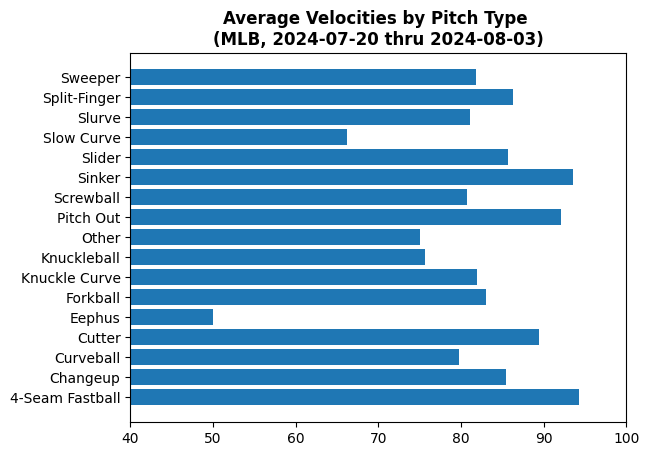

In [93]:
#Plot average pitch velocities
data1 = pitch_data[['pitch_name', 'release_speed']].groupby('pitch_name').release_speed.agg(['mean','count']).reset_index()

plt.barh(data1['pitch_name'], data1['mean'])
plt.xlim((40,100))
plt.title(f'Average Velocities by Pitch Type \n(MLB, {lookup_start} thru {lookup_end})', weight='bold')


In [1]:
#Plot pitch release points for each pitch type, split colors into red (RHP) and green (LHP)
import math
from itertools import product

data2 = pitch_data[['p_throws','pitch_name', 'release_pos_x', 'release_pos_z']]
pitch_names = pitch_data['pitch_name'].drop_duplicates().dropna()

r_patch = patches.Patch(color='red', label='RHP')
l_patch = patches.Patch(color='green', label='LHP')

num_pitches = len(pitch_names)
num_rows = math.ceil(num_pitches/4.0)
subplots = num_rows*4

#Max of 16 subplots, aka, 16 pitch types
fig, axs = plt.subplots(num_rows,4, sharey='row')
for (num,pitch) in enumerate(pitch_names):
    temp = data2[data2['pitch_name'] == pitch]
    axs[num//4, num % 4].scatter(temp['release_pos_x'], temp['release_pos_z'], s=0.5, c=['red' if i=='R' else 'green' for i in temp['p_throws']])
    axs[num//4, num % 4].set_xlim([-5, 5])
    axs[num//4, num % 4].set_title(pitch, fontsize=8, fontweight='bold')
    axs[num//4, num % 4].get_xaxis().set_visible(False)
    axs[num//4, num % 4].get_yaxis().set_visible(False)

#Remove any unused subplots
unused_plots = subplots - num_pitches
plot_indices = [list(i) for i in list(product(list(range(num_rows))[::-1], list(range(4))[::-1]))]
if unused_plots > 0:
    for i in range(unused_plots):
        exec(f'fig.delaxes(axs{plot_indices[i]})') 
    

fig.tight_layout()
fig.suptitle(f'Release points for pitches thrown \n(Home plate view, {lookup_start} thru {lookup_end})', y=1.1, fontweight='bold')
fig.legend(handles=[r_patch, l_patch], loc='lower right')





NameError: name 'pitch_data' is not defined

In [95]:
from scipy.stats import chi2_contingency

X = pitch_data[['release_speed', 'release_pos_x', 'release_pos_z', 'p_throws', 'pfx_x', 'pfx_z', 'spin_axis', 'release_spin_rate', 'pitch_type']].dropna().copy()
y = X.pop('pitch_type')

#First look at p_throws compared to pitch_type
stat, p, dof, exp = chi2_contingency(pd.crosstab(X['p_throws'], y).values)

if p<0.05:
    print(f"P-value = {p}. Reject H0 (Likely relationship between pitching arm and expected pitch type)")
else:

    print(f"P-value = {p}. Fail to reject H0 (Likely no relation between pitching arm and expected pitch type)")




P-value = 5.538784041830968e-152. Reject H0 (Likely relationship between pitching arm and expected pitch type)


([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'release_speed'),
  Text(1, 0, 'release_pos_x'),
  Text(2, 0, 'release_pos_z'),
  Text(3, 0, 'pfx_x'),
  Text(4, 0, 'pfx_z'),
  Text(5, 0, 'spin_axis'),
  Text(6, 0, 'release_spin_rate')])

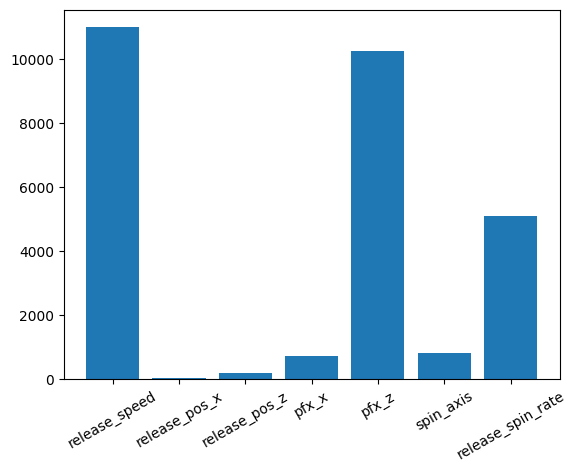

In [96]:
#Now observe numerical variables
fs = SelectKBest(score_func=f_classif, k='all')
fs.fit(X[['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z', 'spin_axis', 'release_spin_rate']], y)
X_fs = fs.transform(X[['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z', 'spin_axis', 'release_spin_rate']])

plt.bar(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z', 'spin_axis', 'release_spin_rate'], fs.scores_)
plt.xticks(rotation=30)
